# Updated Preprocessing && Tuning for High Loss Families

## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
import pandas as pd

from storesales.utils import load_oil, load_stores, make_sales_plot, save_submission
from storesales.feature_engineering import create_date_features
from storesales.preprocessing import preprocess

from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.sales_promo_scaler import SalesPromoScaler
from storesales.light_gbm.lgb_tuner.family_lgb_params import (
    FamilyLightGBMModelParams,
    FamilyLightGBMModelBaseParams,
)
from storesales.light_gbm.lgb_tuner.lgb_model_tuner import LightGBMModelTuner

from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.feature_engineering.rolls_to_features import (
    Roll,
    make_featured_df_from_rolls,
)
from storesales.light_gbm.dataset import make_family_datasets
from storesales.light_gbm.utils import (
    save_family_lightgbm_and_dataset,
    make_submission_predictions,
)
from storesales.light_gbm.constants import (
    TRAINING_DATA_THRESHOLD_TIMESTAMP,
    FEATURES_TO_ROLL,
    START_TARGET_SERIES_TIMESTAMP,
    STATIC_COLS,
    CAT_STATIC_COVS,
    CAT_FUTURE_COVS,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    VALIDATION_DATE_RANGE,
    START_SUBMISSION_DATE,
    START_VALIDATION_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
    EXTERNAL_OIL_PATH,
    EXTERNAL_STORES_PATH,
    MIDDLE_TEST_DATE,
)

In [3]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load && Preprocess Data

In [4]:
families_to_explore = ["HOME AND KITCHEN I", "CELEBRATION", "BEAUTY"]

In [146]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

baseline_train_df = train_df.rename(columns={"date": "ds", "sales": "y"})
baseline_test_df = test_df.rename(columns={"date": "ds"})

stores_df = load_stores(EXTERNAL_STORES_PATH, factorize_cols=["city", "state", "type"])
oil_df = load_oil(EXTERNAL_OIL_PATH)

In [147]:
family_train_df = train_df[train_df["family"].isin(families_to_explore)].copy()
test_family_df = test_df[test_df["family"].isin(families_to_explore)].copy()

In [149]:
default_preprocessed_df = preprocess(
    family_train_df.copy(), make_zero_gaps_replacing=True
)

In [151]:
preprocessed_df = preprocess(
    family_train_df.copy(),
    zero_gap_size_to_replace=10,
    make_zero_gaps_replacing=True,
    make_interpolation=False,
    clipping_quantile=0.99,
)

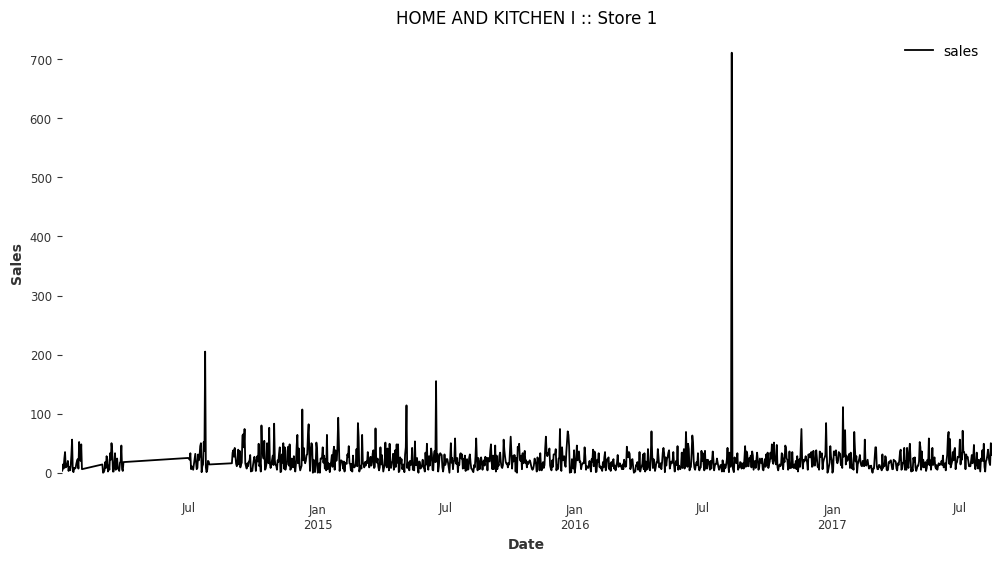

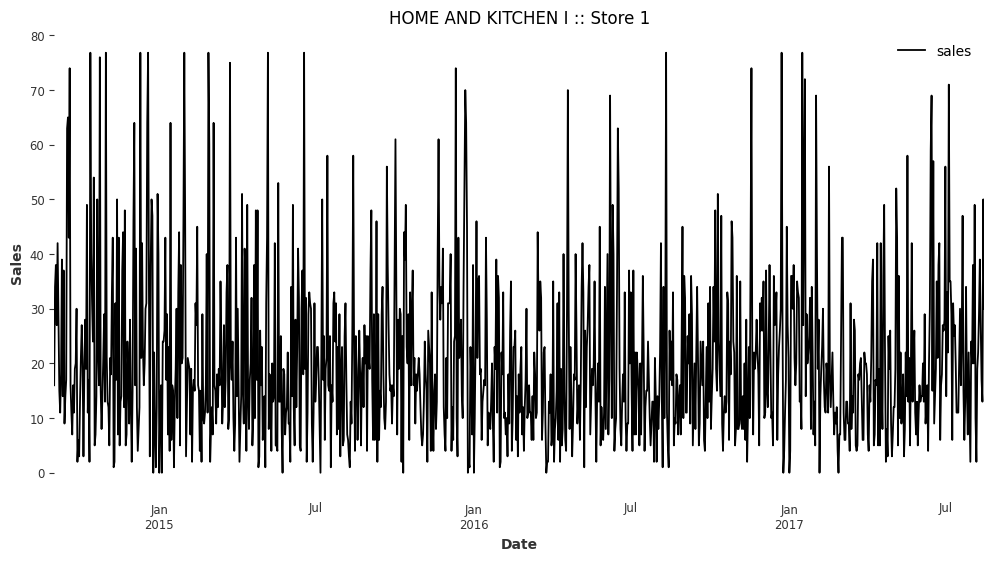

In [9]:
make_sales_plot("HOME AND KITCHEN I", 1, default_preprocessed_df)
make_sales_plot("HOME AND KITCHEN I", 1, preprocessed_df)

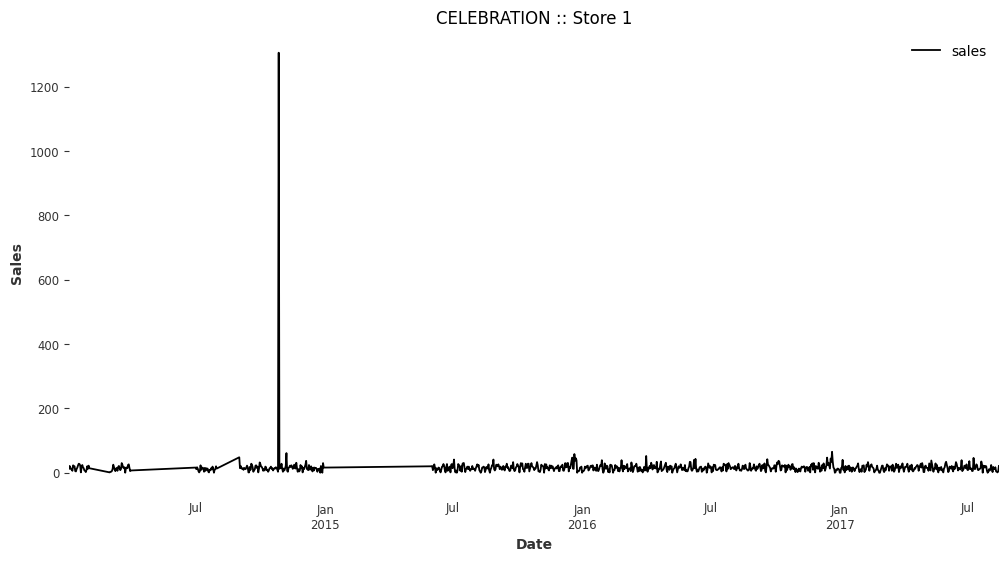

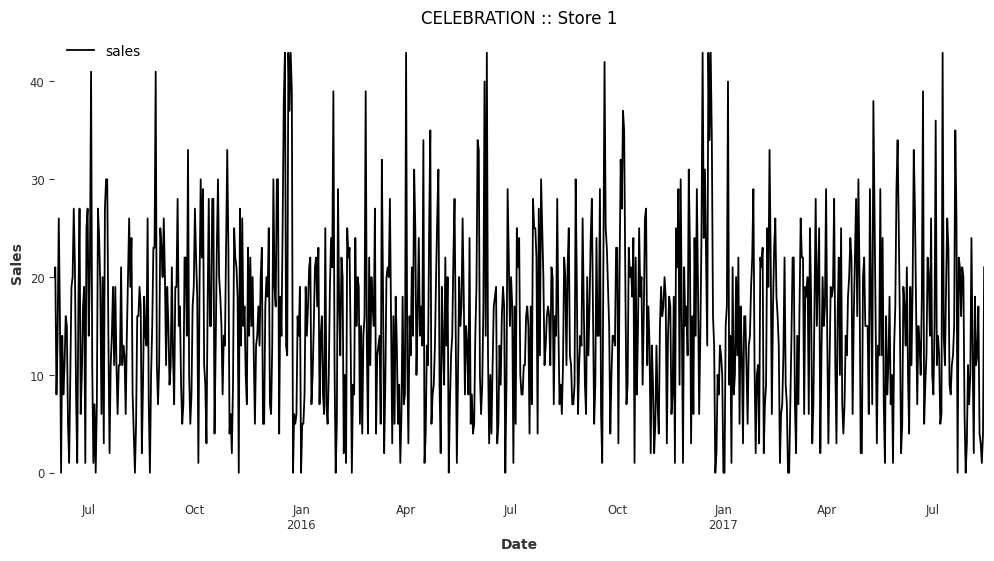

In [10]:
make_sales_plot("CELEBRATION", 1, default_preprocessed_df)
make_sales_plot("CELEBRATION", 1, preprocessed_df)

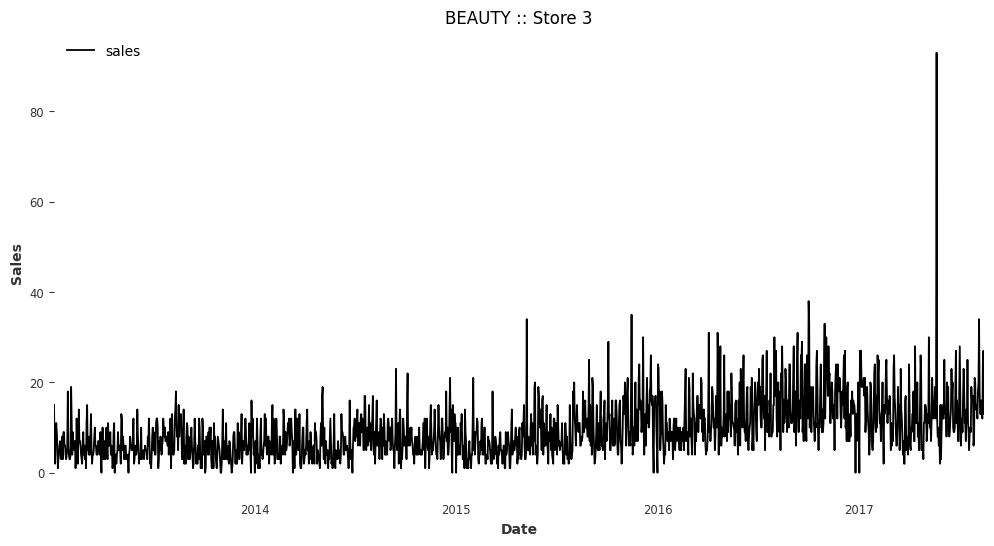

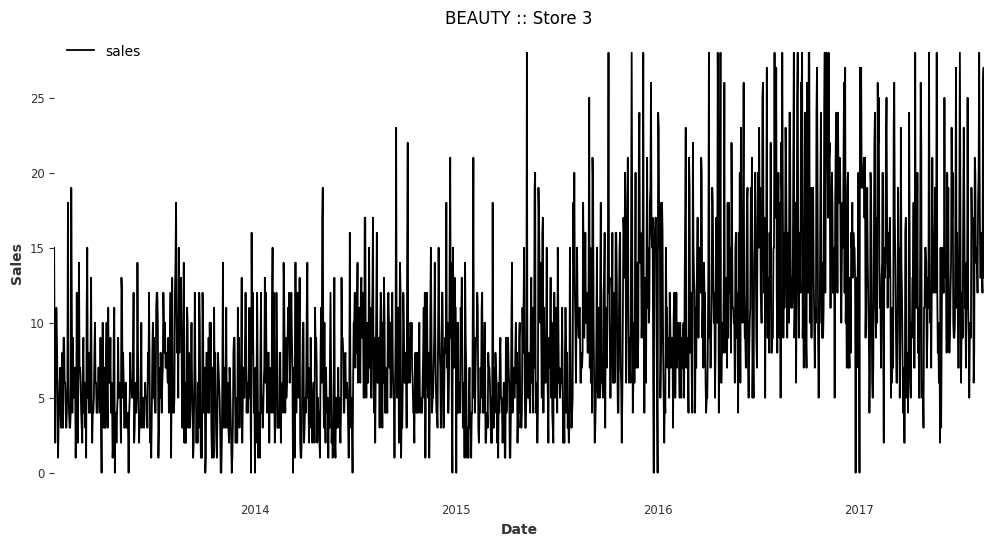

In [90]:
make_sales_plot("BEAUTY", 3, default_preprocessed_df)
make_sales_plot("BEAUTY", 3, preprocessed_df)

In [153]:
def process_df(df):
    data_df = pd.concat([df, test_family_df], ignore_index=True)
    data_df.fillna(0, inplace=True)

    data_df = data_df.merge(oil_df, left_on="date", right_index=True, how="inner")
    data_df = data_df.merge(stores_df, on="store_nbr", how="left")

    min_group_date = data_df.groupby(["family", "store_nbr"])["date"].transform("min")
    return data_df[min_group_date <= TRAINING_DATA_THRESHOLD_TIMESTAMP]

In [154]:
default_preprocessed_df = process_df(default_preprocessed_df)
preprocessed_df = process_df(preprocessed_df)

In [158]:
def get_std_for_each_family_store(df):
    std_df = df.groupby(["family", "store_nbr"])["sales"].std()
    return std_df


def print_data_info(df):
    print(f"data length:", df.shape[0])
    print(f"contains zeros: {(df['sales'] == 0).sum()}")
    print("\nstd for each family store:")
    print(get_std_for_each_family_store(df).groupby("family").mean())
    print("\nn stores in each family:")
    print(df.groupby("family")["store_nbr"].nunique())

In [155]:
print_data_info(default_preprocessed_df)

data length: 221101
contains zeros: 19311

std for each family store:
family
BEAUTY                 3.073632
CELEBRATION           10.755142
HOME AND KITCHEN I    27.577060
Name: sales, dtype: float64

n stores in each family:
family
BEAUTY                53
CELEBRATION           53
HOME AND KITCHEN I    53
Name: store_nbr, dtype: int64


In [156]:
print_data_info(preprocessed_df)

data length: 156952
contains zeros: 9966

std for each family store:
family
BEAUTY                 3.423930
CELEBRATION            8.919748
HOME AND KITCHEN I    21.447519
Name: sales, dtype: float64

n stores in each family:
family
BEAUTY                41
CELEBRATION           50
HOME AND KITCHEN I    51
Name: store_nbr, dtype: int64


#### Scale Data

In [14]:
def fit_transform(df, scaler_obj):
    scaler_obj.fit(df[df["date"] < START_VALIDATION_DATE])
    return scaler_obj.transform(df)

In [157]:
default_scaler = SalesPromoScaler()
scaler = SalesPromoScaler()

default_preprocessed_df = fit_transform(default_preprocessed_df, default_scaler)
preprocessed_df = fit_transform(preprocessed_df, scaler)

#### Rolling Features

In [17]:
fc_parameters = {"mean": None, "standard_deviation": None}

In [18]:
def make_rolls_df(df):
    short_rolls = Roll(
        name="short",
        timeshift=7,
        features=FEATURES_TO_ROLL,
        default_fc_parameters=fc_parameters,
    )
    long_rolls = Roll(
        name="long",
        timeshift=28,
        features=FEATURES_TO_ROLL,
        default_fc_parameters=fc_parameters,
    )

    return make_featured_df_from_rolls(df=df, rolls=[short_rolls, long_rolls])

In [19]:
default_train_featured_df = make_rolls_df(default_preprocessed_df)
train_featured_df = make_rolls_df(preprocessed_df)

Feature Extraction: 100%|██████████| 30/30 [02:11<00:00,  4.38s/it]


In [20]:
default_date_features_df = create_date_features(
    default_train_featured_df, pref="date_feature_"
)
default_date_feature_cols = default_date_features_df.columns.to_list()

default_train_featured_df[default_date_feature_cols] = default_date_features_df

In [21]:
date_features_df = create_date_features(train_featured_df, pref="date_feature_")
date_feature_cols = date_features_df.columns.to_list()

train_featured_df[date_feature_cols] = date_features_df

#### Specify Lags

In [22]:
sales_cols = [col for col in train_featured_df.columns if "sales_" in col]
onpromotion_cols = [col for col in train_featured_df.columns if "onpromotion_" in col]
oil_cols = [col for col in train_featured_df.columns if "dcoilwtico_" in col]

In [23]:
future_cols = (
    onpromotion_cols + oil_cols + default_date_feature_cols + date_feature_cols
)
past_cols = sales_cols

#### Make Family Datasets


In [24]:
def get_series_data_df(df):
    start_series_mask = df["date"] > START_TARGET_SERIES_TIMESTAMP
    return df[start_series_mask].copy()

In [25]:
default_series_data = get_series_data_df(default_preprocessed_df)
series_data = get_series_data_df(preprocessed_df)

In [26]:
default_family_datasets = make_family_datasets(
    df=default_series_data,
    scaler=default_scaler,
    series_value_column="sales",
    featured_df=default_train_featured_df,
    static_cols=STATIC_COLS,
    future_cols=future_cols,
    past_cols=past_cols,
    train_end_date=START_VALIDATION_DATE,
    start_submission_date=START_SUBMISSION_DATE,
)

family_datasets = make_family_datasets(
    df=series_data,
    scaler=scaler,
    series_value_column="sales",
    featured_df=train_featured_df,
    static_cols=STATIC_COLS,
    future_cols=future_cols,
    past_cols=past_cols,
    train_end_date=START_VALIDATION_DATE,
    start_submission_date=START_SUBMISSION_DATE,
)

### Tune && Eval LightGBM Models
#### Tune Models

In [27]:
use_default_model_params = True
n_tune_trials = 1

if use_default_model_params:
    param_suggestor_class = FamilyLightGBMModelBaseParams
else:
    param_suggestor_class = FamilyLightGBMModelParams

In [28]:
param_suggestor = param_suggestor_class(
    n_jobs=6,
    lags=65,
    lags_future_covariates=[i for i in range(0, -17, -1)],
    lags_past_covariates=[i for i in range(-16, -47, -1)],
    categorical_static_covariates=CAT_STATIC_COVS,
    categorical_future_covariates=CAT_FUTURE_COVS,
)

In [29]:
default_tuner = LightGBMModelTuner(
    family_datasets=default_family_datasets, param_suggestor=param_suggestor
)
tuner = LightGBMModelTuner(
    family_datasets=family_datasets, param_suggestor=param_suggestor
)

In [30]:
print("Default Preprocessed Dataset Tune...")
default_tuner.run_tune(
    evaluate_range=VALIDATION_DATE_RANGE, eval_stride=1, n_trials=n_tune_trials
)

print("Advanced Preprocessed Dataset Tune...")
tuner.run_tune(
    evaluate_range=VALIDATION_DATE_RANGE, eval_stride=1, n_trials=n_tune_trials
)

Default Preprocessed Dataset Tune...
Optimizing BEAUTY model...


  0%|          | 0/1 [00:00<?, ?it/s]

Optimizing CELEBRATION model...


  0%|          | 0/1 [00:00<?, ?it/s]

Optimizing HOME AND KITCHEN I model...


  0%|          | 0/1 [00:00<?, ?it/s]

Advanced Preprocessed Dataset Tune...
Optimizing BEAUTY model...


  0%|          | 0/1 [00:00<?, ?it/s]

Optimizing CELEBRATION model...


  0%|          | 0/1 [00:00<?, ?it/s]

Optimizing HOME AND KITCHEN I model...


  0%|          | 0/1 [00:00<?, ?it/s]

#### Fit Best Models

In [31]:
default_best_lgb_models = default_tuner.parallel_fit_best(n_jobs=3)
best_lgb_models = tuner.parallel_fit_best(n_jobs=3)

#### Evaluate Models

In [32]:
default_eval_results = evaluate(
    dataset=default_family_datasets,
    models=default_best_lgb_models,
    evaluate_range=TEST_DATE_RANGE,
    stride=1,
    n_jobs=3,
)
eval_results = evaluate(
    dataset=family_datasets,
    models=best_lgb_models,
    evaluate_range=TEST_DATE_RANGE,
    stride=1,
    n_jobs=3,
)

### Explore Losses

In [130]:
default_lightgbm_prediction_df = make_submission_predictions(
    family_datasets=default_family_datasets, models=default_best_lgb_models
)

lightgbm_prediction_df = make_submission_predictions(
    family_datasets=family_datasets, models=best_lgb_models
)

100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


In [131]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]

In [132]:
default_advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=default_eval_results,
    lightgbm_model_prediction_df=default_lightgbm_prediction_df.reset_index(),
)

advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_results,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

100%|██████████| 1782/1782 [00:45<00:00, 38.77it/s]


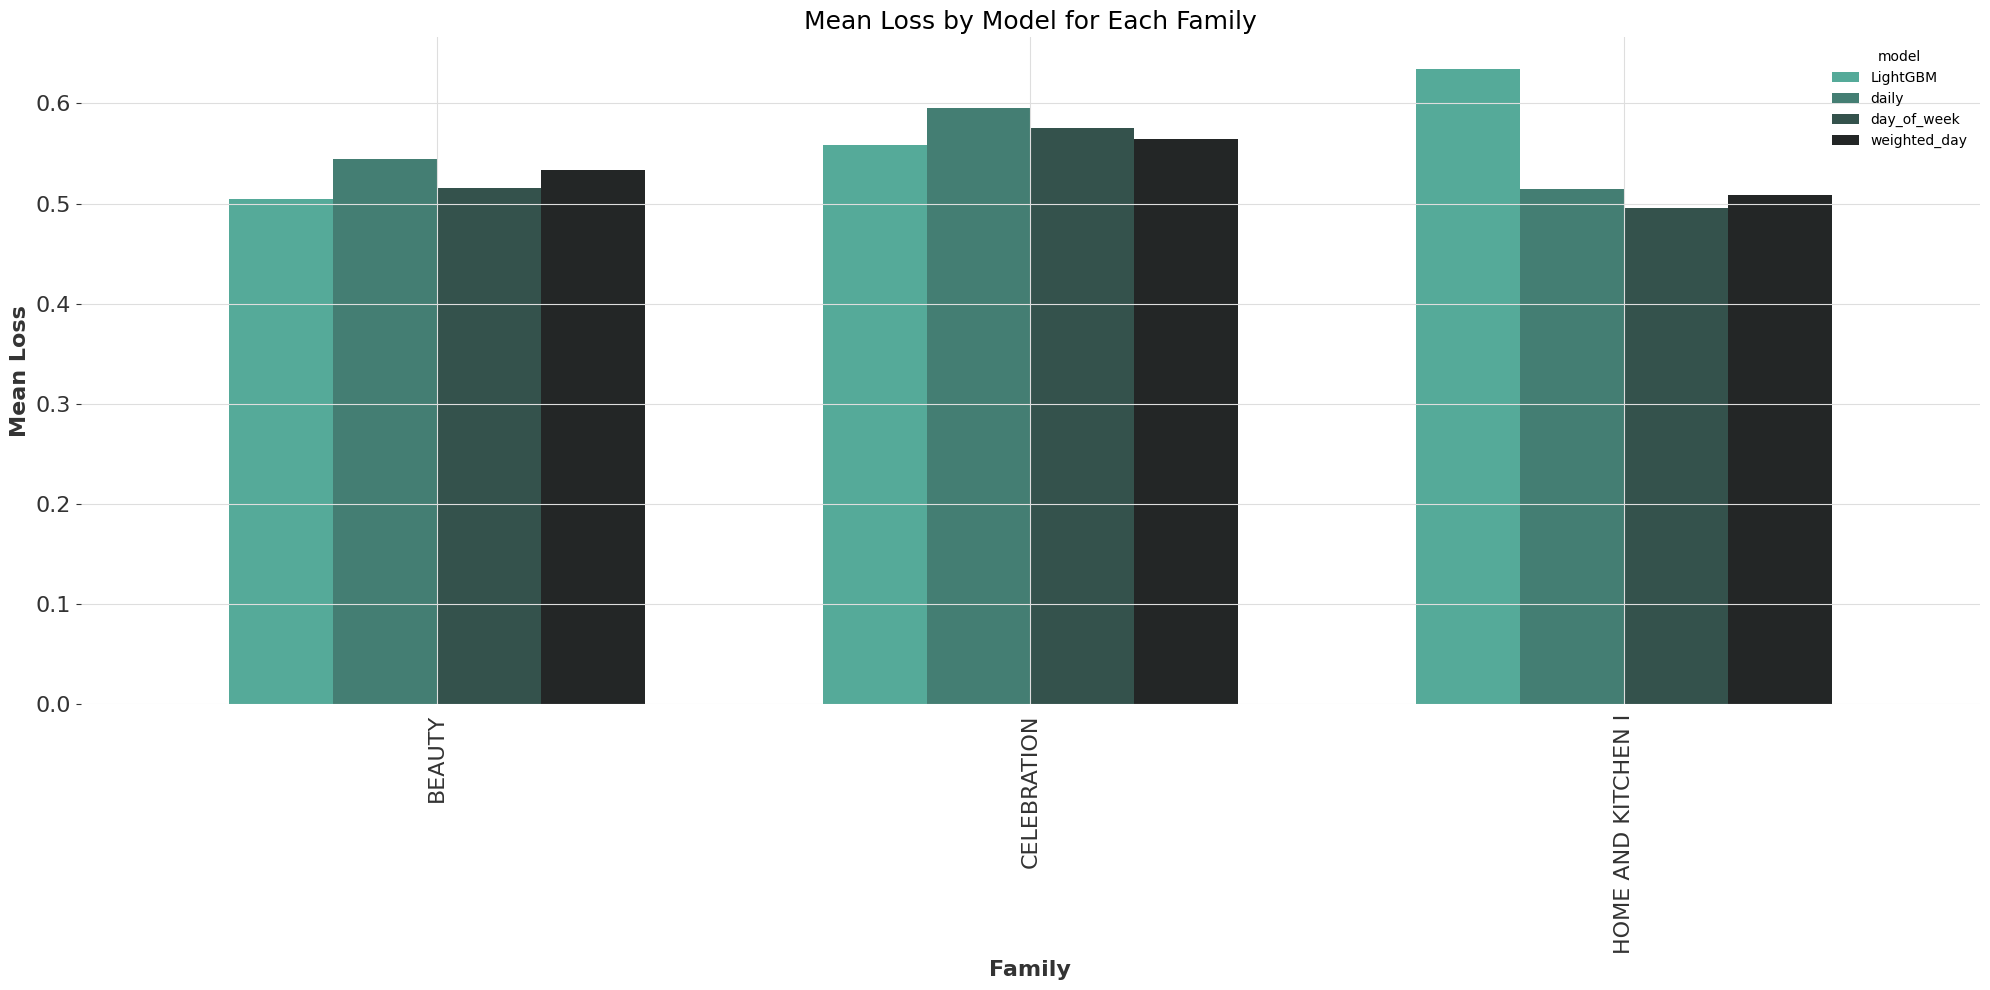

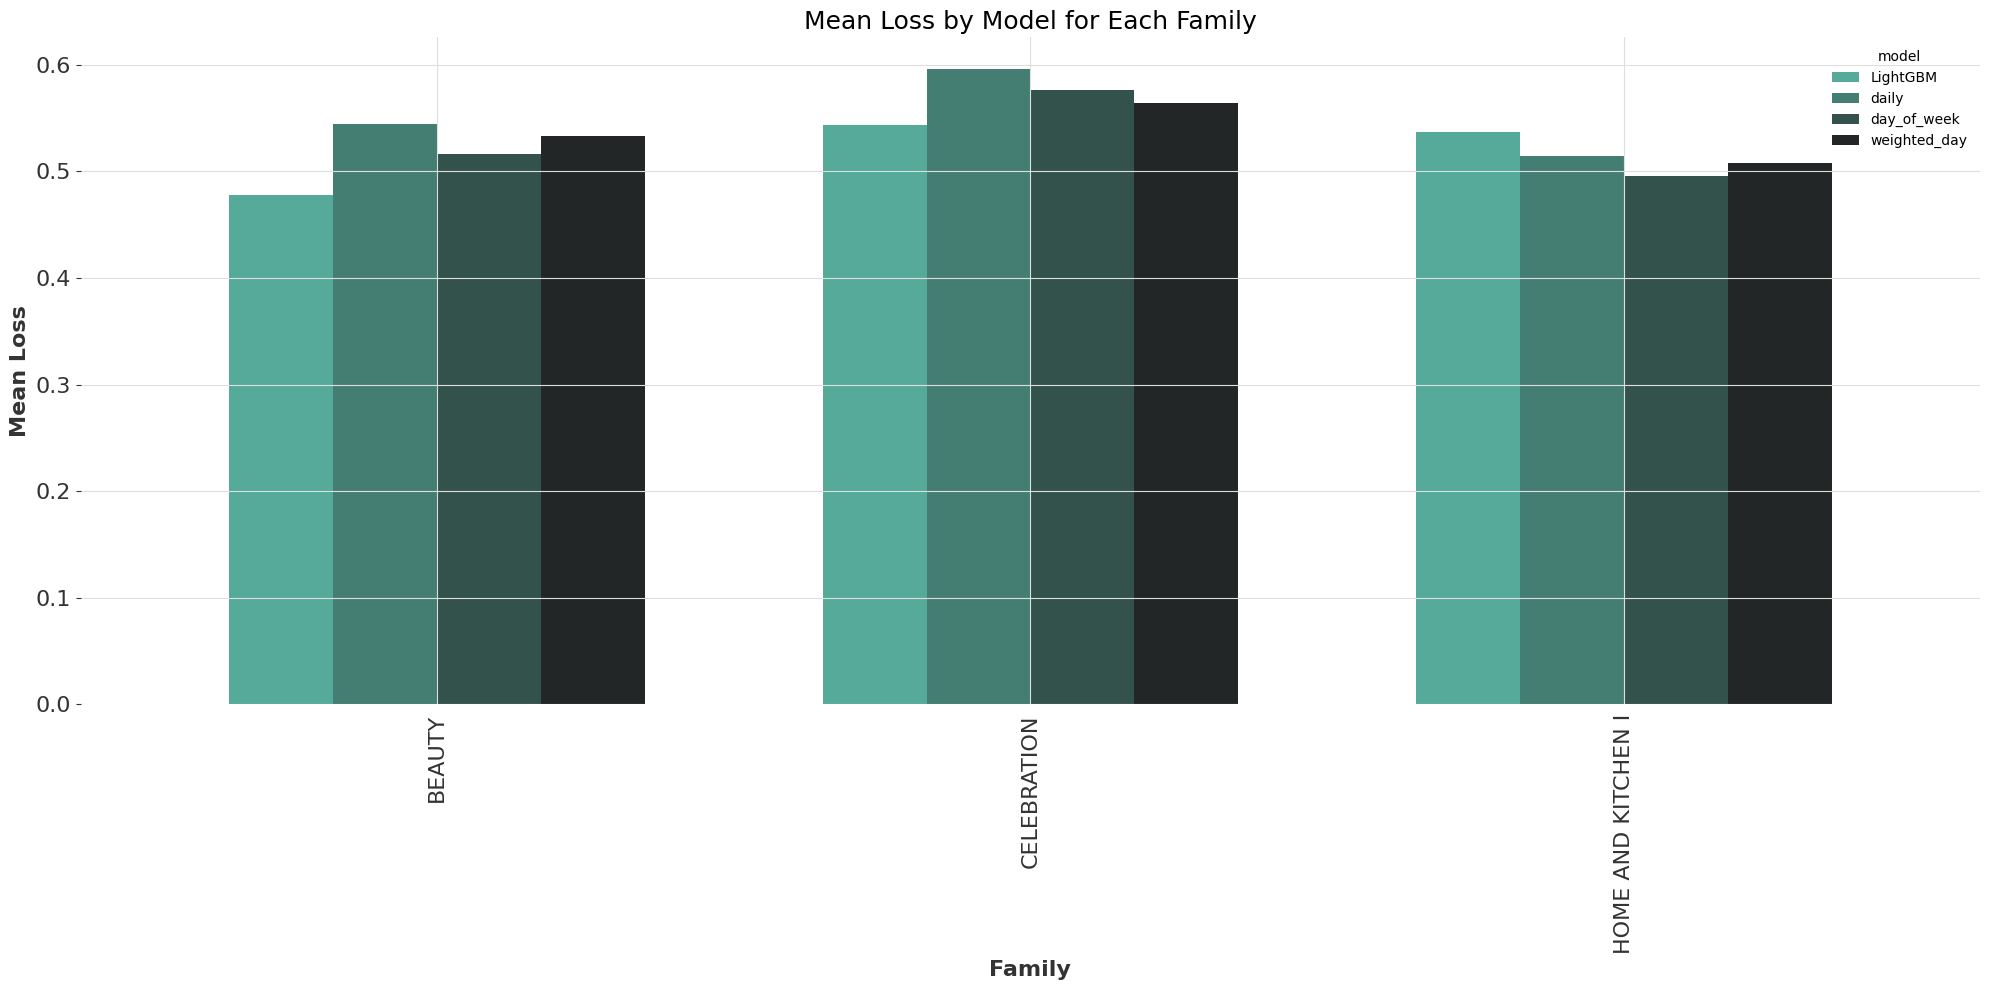

In [168]:
default_advanced_predictor.make_overall_family_loss_plot(
    test_loss=True, families=families_to_explore
)
advanced_predictor.make_overall_family_loss_plot(
    test_loss=True, families=families_to_explore
)

In [159]:
losses = []

predictors = [default_advanced_predictor, advanced_predictor]
names = ["default", "advanced"]
for predictor, name in zip(predictors, names):
    optimal_idx = predictor.get_optimal_model_ids(strategy="combined")
    family_mean_loss = predictor.calc_mean_loss(optimal_idx).rename(name)
    losses.append(family_mean_loss)


total_loss_df = pd.concat(losses, axis=1)
total_loss_df.loc[families_to_explore]

,default,advanced
family,,
HOME AND KITCHEN I,0.495171,0.483205
CELEBRATION,0.555457,0.548557
BEAUTY,0.500475,0.499685


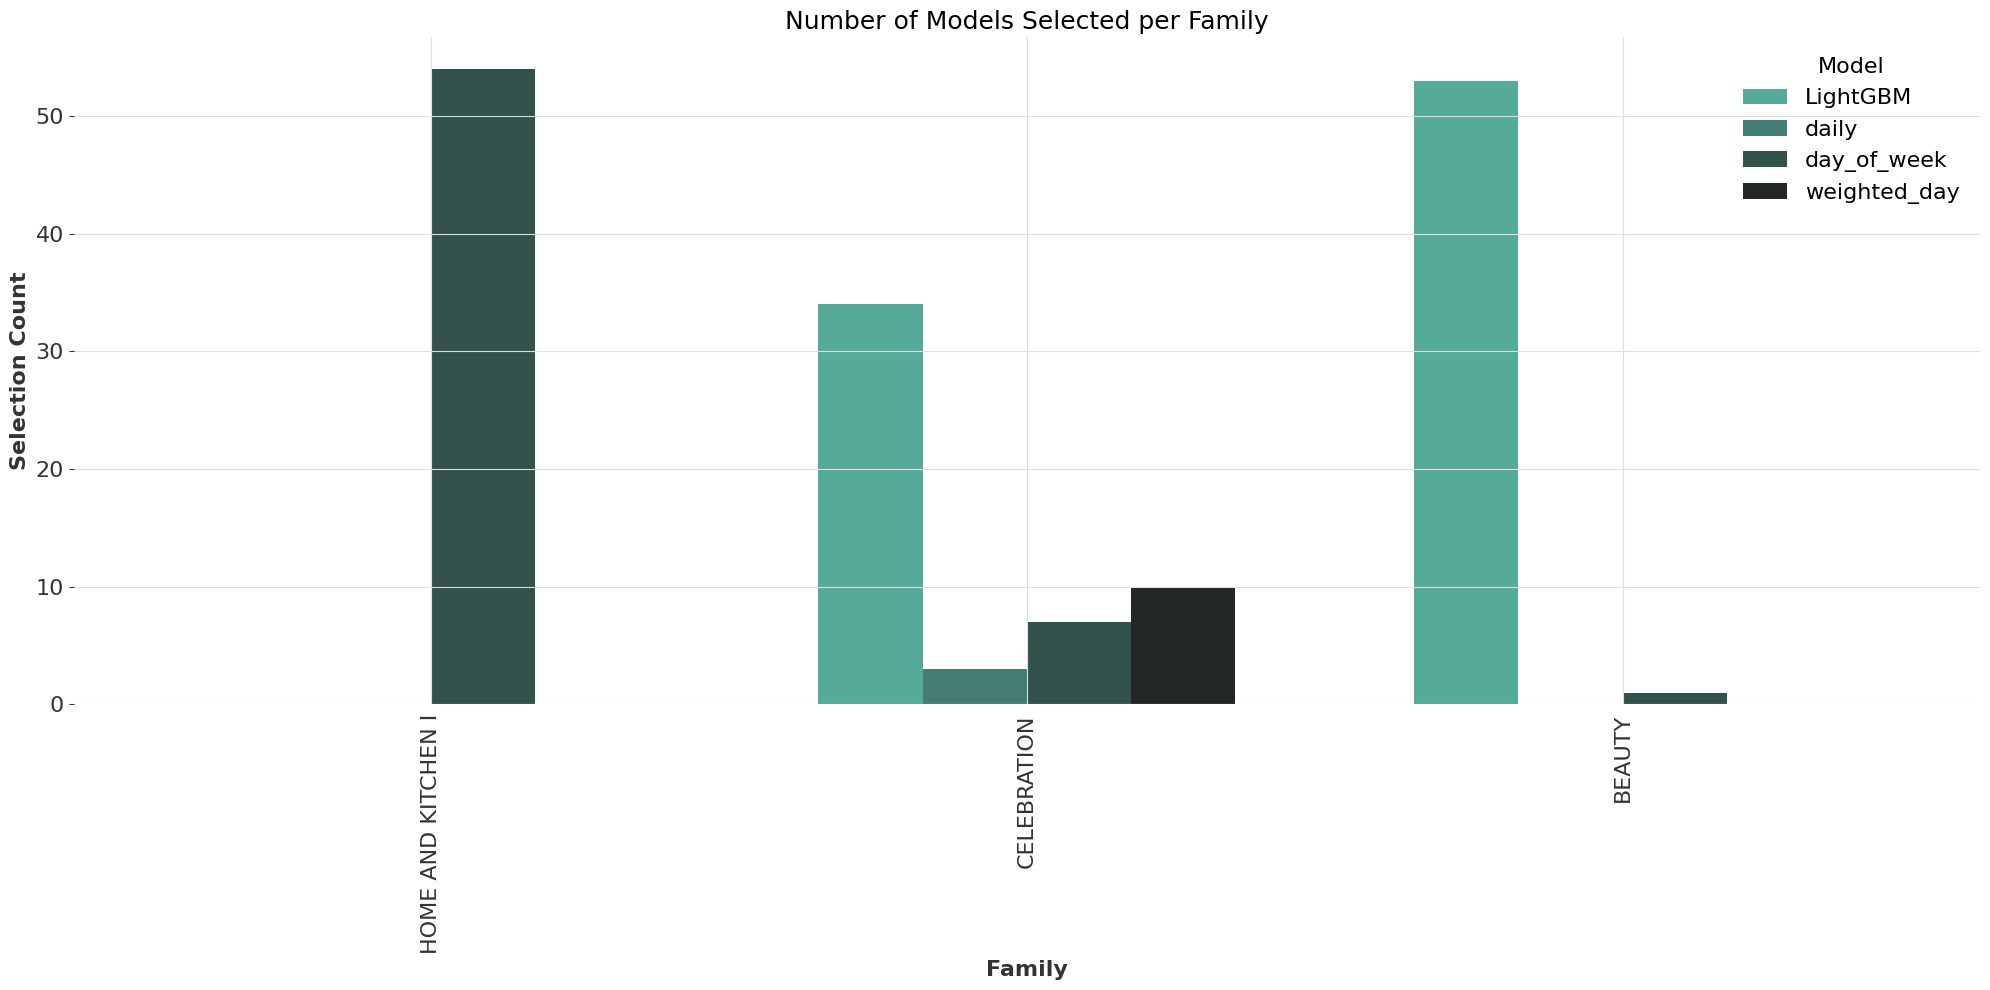

In [165]:
min_loss_ids = default_advanced_predictor.get_optimal_model_ids(strategy="combined")
default_advanced_predictor.make_model_selection_plot(
    min_loss_ids, families=families_to_explore
)

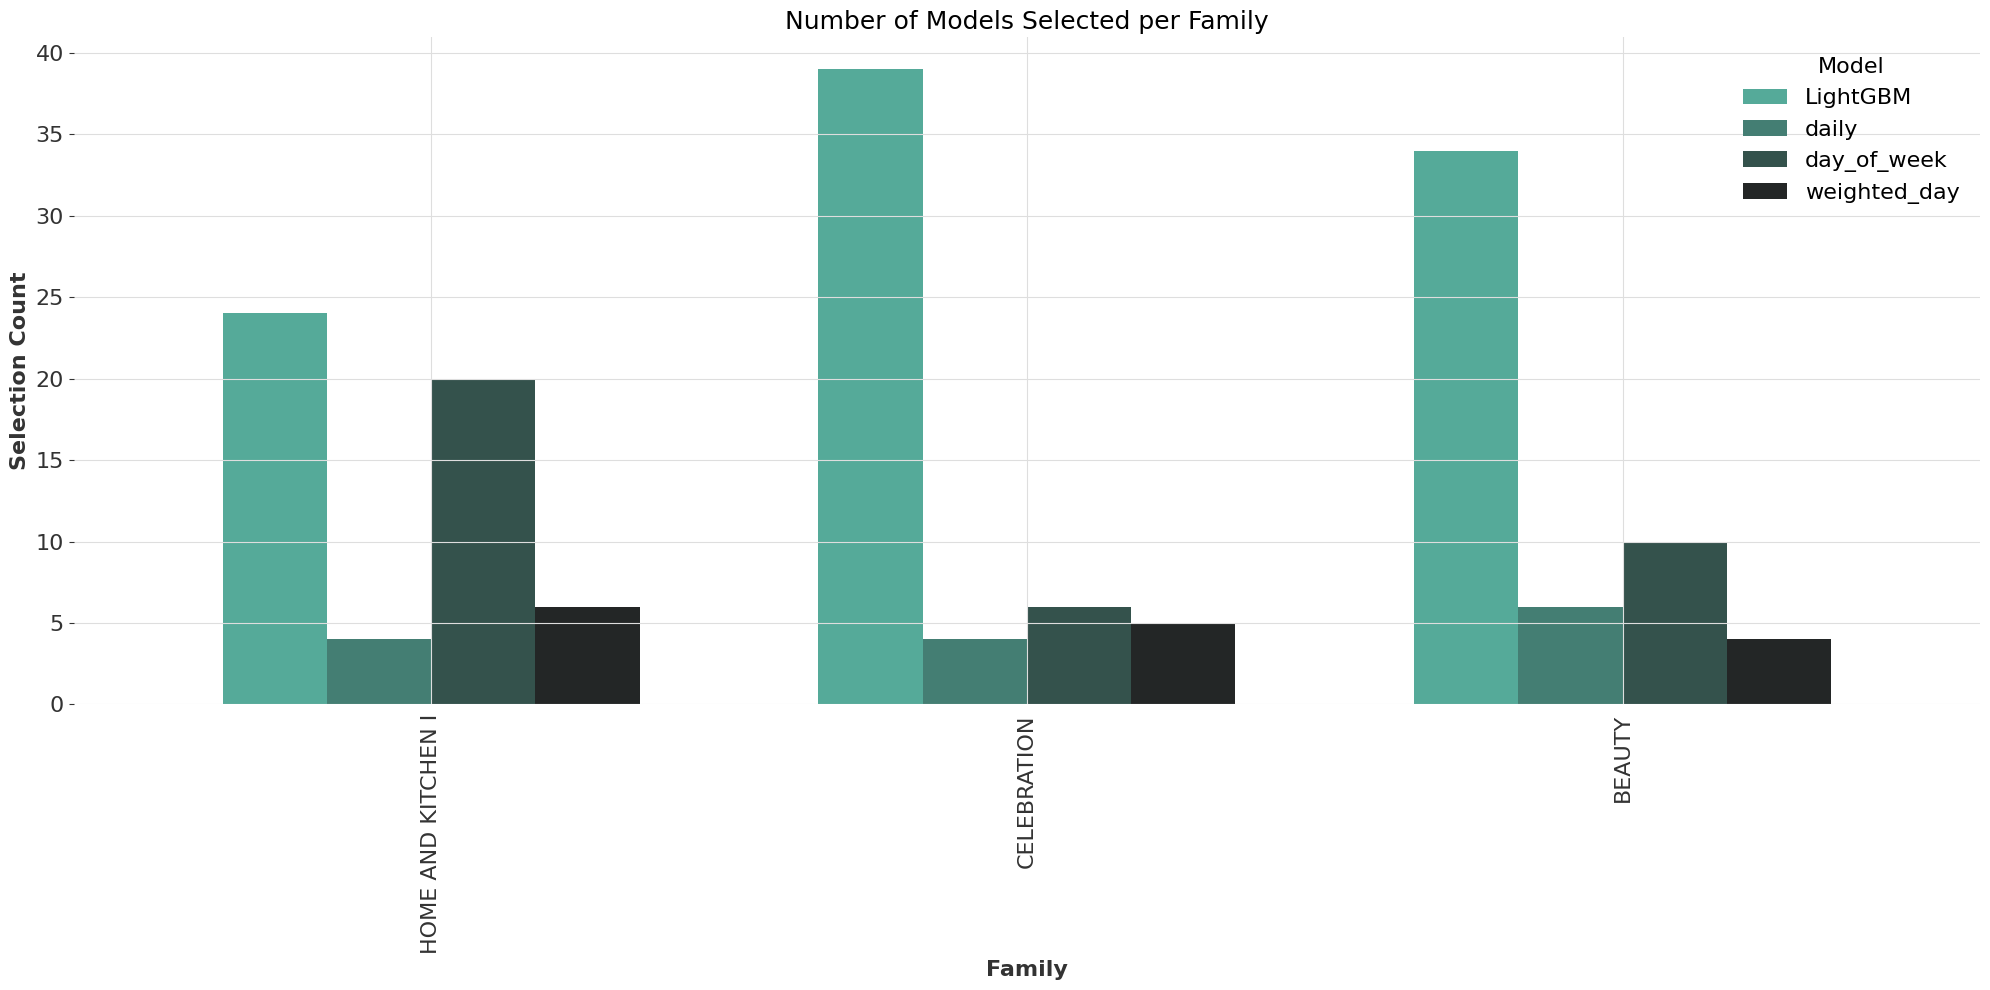

In [166]:
min_loss_ids = advanced_predictor.get_optimal_model_ids(strategy="combined")
advanced_predictor.make_model_selection_plot(min_loss_ids, families=families_to_explore)

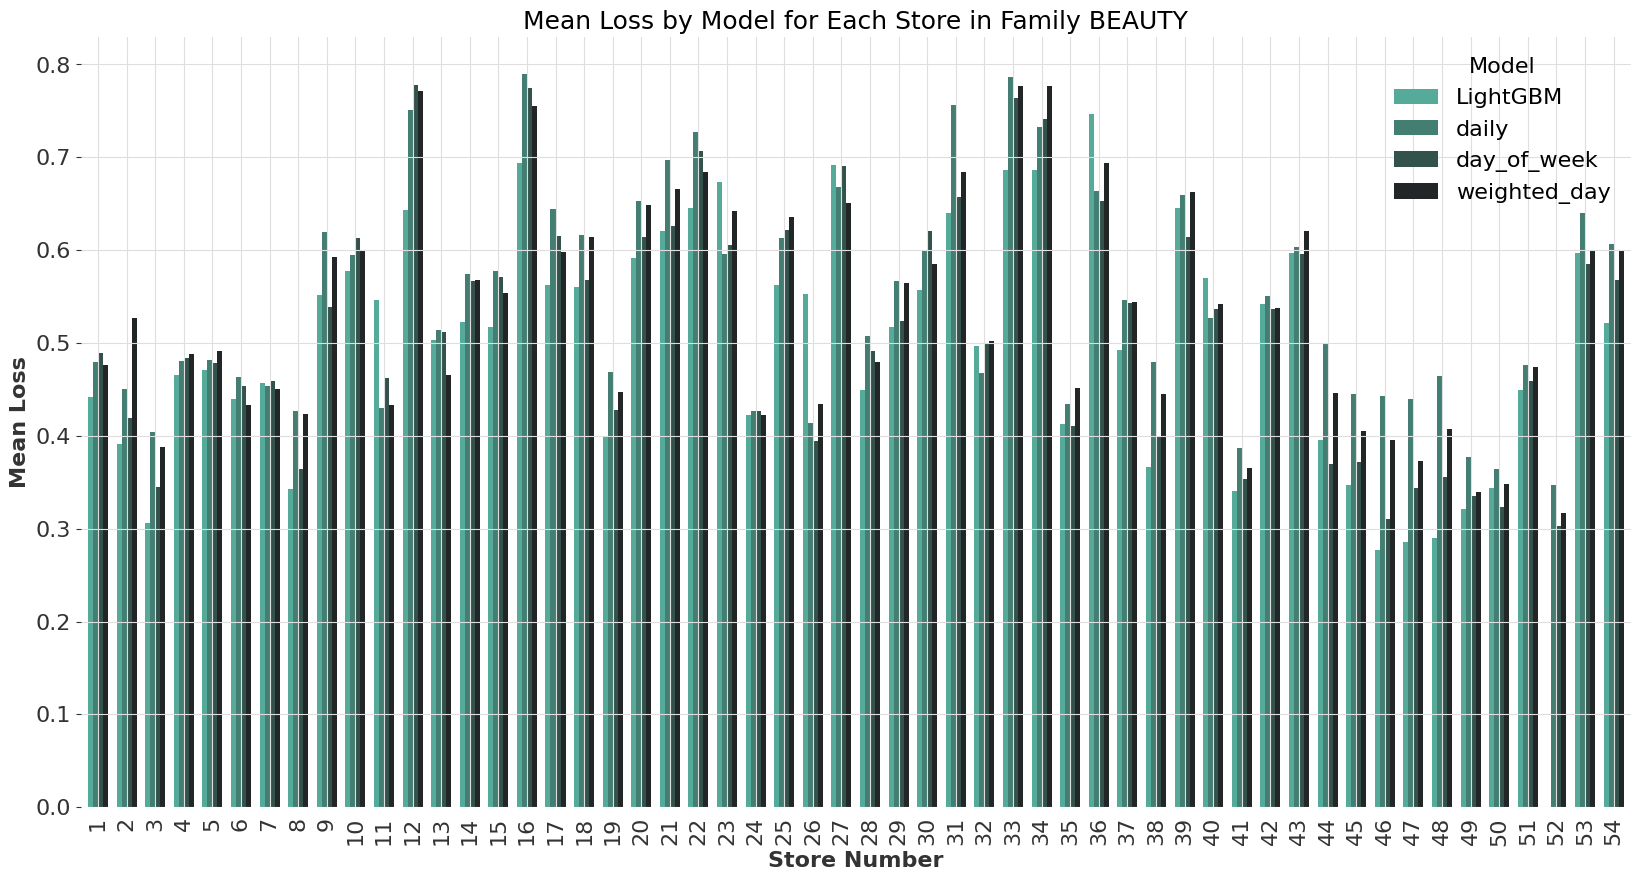

<Figure size 640x480 with 0 Axes>

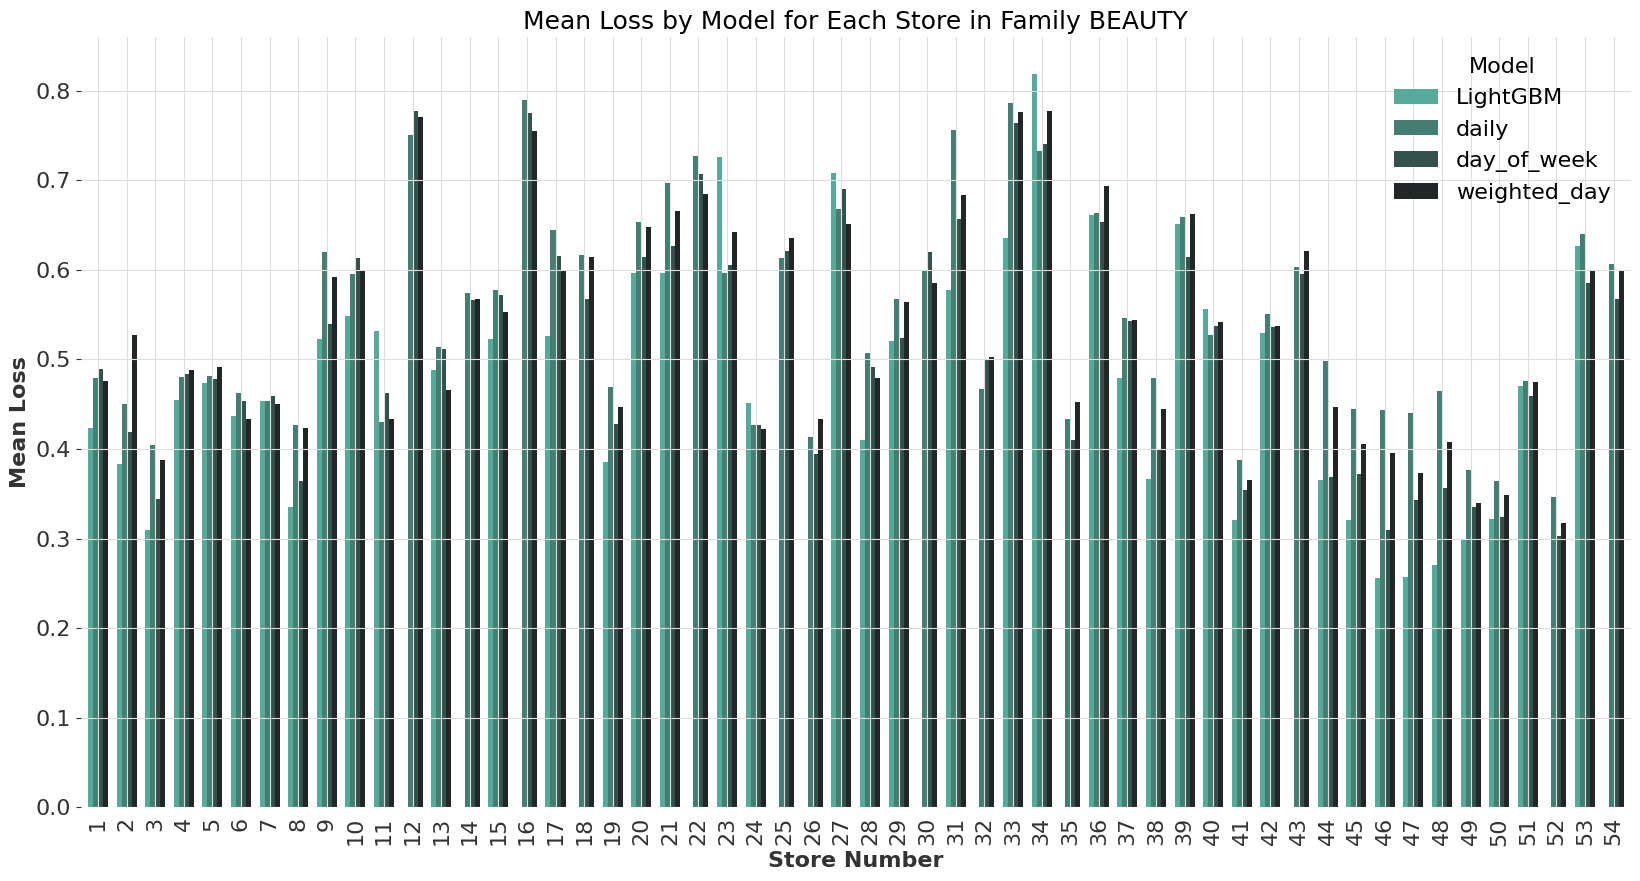

<Figure size 640x480 with 0 Axes>

In [170]:
default_advanced_predictor.make_family_loss_plot(family="BEAUTY", test_loss=True)
advanced_predictor.make_family_loss_plot(family="BEAUTY", test_loss=True)

In [141]:
def save_submissions(sales_predictor, file_name):
    prediction_df = sales_predictor.get_optimal_prediction(strategy="combined")
    return save_submission(df=prediction_df, file_name=file_name)

In [142]:
files_for_submission = ["default_advanced_submission.csv", "advanced_submission.csv"]

In [143]:
for predictor, f_name in zip(predictors, files_for_submission):
    save_submissions(predictor, f_name)

Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/default_advanced_submission.csv
Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/advanced_submission.csv


## Save Models

In [35]:
save_suffix = "_new_preprocessing"

In [36]:
for family, model in best_lgb_models.items():
    save_family_lightgbm_and_dataset(
        family=family,
        model=model,
        family_dataset=family_datasets[family],
        dir_suffix=save_suffix,
    )

In [37]:
save_suffix = "_old_preprocessing"

In [38]:
for family, model in default_best_lgb_models.items():
    save_family_lightgbm_and_dataset(
        family=family,
        model=model,
        family_dataset=default_family_datasets[family],
        dir_suffix=save_suffix,
    )